In [1]:
!pip install qiskit==1.4.0
!pip install numpy
!pip install qiskit-machine-learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

In [23]:
import copy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score
torch.set_default_dtype(torch.float32)
# Read Train Data
datafile = "features_train.csv"
df = pd.read_csv(datafile, sep=',', header=0)
embedding_features_train = df.to_numpy()
np.random.shuffle(embedding_features_train)

embedding_values_train = [np.fromstring(embedding_features_train[i][1][1:-1], sep=',', dtype=np.longdouble) for i in range(embedding_features_train.shape[0])] # a list of numpy arrays
embedding_labels_train = np.array([int(np.array(embedding_features_train[i][0][-1])) for i in range(embedding_features_train.shape[0])]) # another list of numpy arrays (targets)
# Preprocess Train Data
pca = PCA(n_components=4, random_state=42)
X_pca_train = pca.fit_transform(embedding_values_train)
X_pca_train_scaled = MinMaxScaler().fit_transform(X_pca_train)

train_images = X_pca_train_scaled
train_labels = embedding_labels_train

# Read Test Data
datafile = "features_test.csv"
df = pd.read_csv(datafile, sep=',', header=0)
embedding_features_test = df.to_numpy()
np.random.shuffle(embedding_features_test)

embedding_values_test = [np.fromstring(embedding_features_test[i][1][1:-1], sep=',', dtype=np.longdouble) for i in range(embedding_features_test.shape[0])] # a list of numpy arrays
embedding_labels_test = np.array([int(np.array(embedding_features_test[i][0][-1])) for i in range(embedding_features_test.shape[0])]) # another list of numpy arrays (targets)

X_pca_test = pca.fit_transform(embedding_values_test)
X_pca_test_scaled = MinMaxScaler().fit_transform(X_pca_test)

test_images = X_pca_test_scaled
test_labels = embedding_labels_test

# Read Test Data
datafile = "features_val.csv"
df = pd.read_csv(datafile, sep=',', header=0)
embedding_features_val = df.to_numpy()
np.random.shuffle(embedding_features_val)

embedding_values_val = [np.fromstring(embedding_features_val[i][1][1:-1], sep=',') for i in range(embedding_features_val.shape[0])] # a list of numpy arrays
embedding_labels_val = np.array([int(np.array(embedding_features_val[i][0][-1])) for i in range(embedding_features_val.shape[0])]) # another list of numpy arrays (targets)

X_pca_val = pca.fit_transform(embedding_values_test)
X_pca_val_scaled = MinMaxScaler().fit_transform(X_pca_test)

val_images = X_pca_val_scaled
val_labels = embedding_labels_train

In [ ]:
from qiskit.circuit.library import z_feature_map

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

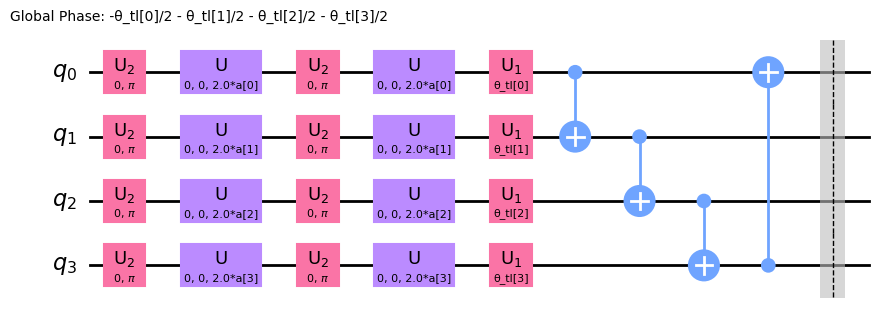

In [15]:
from qiskit.circuit import Parameter, ParameterVector

# Combine the feature map with the ansatz
ansatz_twolocal = QuantumCircuit(num_qubits)
theta_twolocal = ParameterVector('θ_tl', num_qubits)

layer_tl = 1
for _ in range(layer_tl):
    for i in range(num_qubits): ansatz_twolocal.rz(theta_twolocal[i], i) 
    for i in range(num_qubits-1): ansatz_twolocal.cx(i, i+1)
    ansatz_twolocal.cx(num_qubits-1, 0)
ansatz_twolocal.barrier()

full_circuit_twolocal = QuantumCircuit(num_qubits)
full_circuit_twolocal.compose(feature_map, range(num_qubits), inplace=True)
full_circuit_twolocal.compose(ansatz_twolocal, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit_twolocal.decompose().draw("mpl", style="clifford", fold=-1)

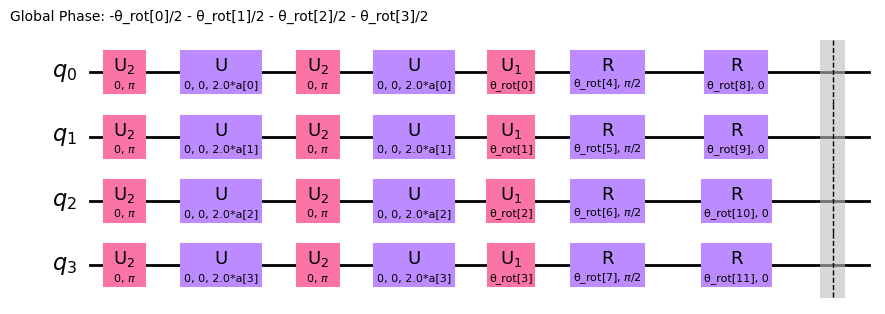

In [16]:
from qiskit.circuit import Parameter, ParameterVector

# Combine the feature map with the ansatz
ansatz_rot = QuantumCircuit(num_qubits)
theta_rot = ParameterVector('θ_rot', 3*num_qubits)

for i in range(num_qubits):
    ansatz_rot.rz(theta_rot[i], i) 
    ansatz_rot.ry(theta_rot[num_qubits+i], i) 
    ansatz_rot.rx(theta_rot[2*num_qubits+i], i) 

ansatz_rot.barrier()

full_circuit_rot = QuantumCircuit(num_qubits)
full_circuit_rot.compose(feature_map, range(num_qubits), inplace=True)
full_circuit_rot.compose(ansatz_rot, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit_rot.decompose().draw("mpl", style="clifford", fold=-1)

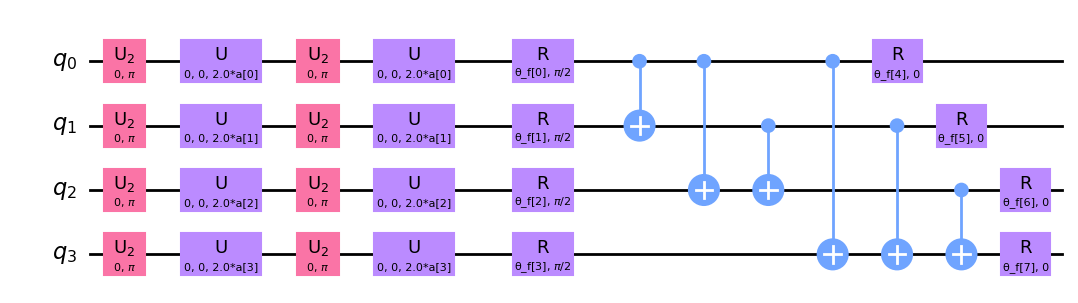

In [17]:
from qiskit.circuit import ParameterVector

ansatz_full = QuantumCircuit(num_qubits)
params_full = ParameterVector("θ_f", length=2 * num_qubits)

for i in range(num_qubits):
    ansatz_full.ry(params_full[i], i)

combs = combinations(range(num_qubits),2)
for i,j in combs:
    ansatz_full.cx(i,j)

for i in range(num_qubits):
    ansatz_full.rx(params_full[num_qubits + i], i)

"""for i in range(num_qubits):
    ansatz_full.ry(params_full[2*num_qubits + i], i)

combs = combinations(range(num_qubits),2)
for i,j in combs:
    ansatz_full.cx(i,j)

for i in range(num_qubits):
    ansatz_full.rx(params_full[3*num_qubits + i], i)"""

# Combine the feature map with the ansatz
full_circuit_2 = QuantumCircuit(num_qubits)
full_circuit_2.compose(feature_map, range(num_qubits), inplace=True)
full_circuit_2.compose(ansatz_full, range(num_qubits), inplace=True)

# Display the circuit
full_circuit_2.decompose().draw("mpl", style="clifford", fold=-1)

In [18]:
from qiskit.primitives import StatevectorSampler as Sampler
weight_params = np.random.rand(len(ansatz_twolocal.parameters))
sampler = Sampler()
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=full_circuit_twolocal,
    input_params=feature_map.parameters,
    weight_params=ansatz_twolocal.paramete2rs,
    sampler=sampler,
    input_gradients=True
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [19]:
qnn_torch = TorchConnector(sampler_qnn)

In [20]:
import torch.nn as nn
import torch.optim as optim
class QuantumNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.quantum_layer = TorchConnector(sampler_qnn)
        self.fc4 = nn.Linear(2**num_qubits, 8)
    def forward(self, x):
        x = self.quantum_layer(x)
        x = self.fc4(x)
        return x

In [21]:
model = QuantumNN(num_classes=8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [32]:
import time
import torch
from tqdm import tqdm
train_losses = []
accuracies = []
test_accuracies = []
predictions = []

start_time = time.time()
EPOCHS = 20
batch_size = 32

data_torch = torch.tensor(train_images, dtype=torch.float32)

eight_level = {0: [0,0,0,0,0,0,0,1], 1: [0,0,0,0,0,0,1,0], 2: [0,0,0,0,0,1,0,0], 3: [0,0,0,0,1,0,0,0],
               4: [0,0,0,1,0,0,0,0], 5: [0,0,1,0,0,0,0,0], 6: [0,1,0,0,0,0,0,0], 7: [1,0,0,0,0,0,0,0]}
target_1x8 = np.array([np.array(eight_level[label]) for label in train_labels])
target_torch = torch.tensor(target_1x8, dtype=torch.float32)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i in range((len(target_torch) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        
        data = data_torch[start_i:end_i]
        target = target_torch[start_i:end_i]
        target_labels = train_labels[start_i:end_i]
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        predicted_correct = [7-int(predicted[i]) for i in range(len(predicted))]
        total += target.size(0)
        correct += (predicted_correct == target_labels).sum().item()
        predictions.append(predicted_correct)
        
        print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_labels)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Epoch 1, Batch 0, Loss: 2.1387
Epoch 1, Batch 1, Loss: 2.1123
Epoch 1, Batch 2, Loss: 2.1024
Epoch 1, Batch 3, Loss: 2.1498
Epoch 1, Batch 4, Loss: 2.1301
Epoch 1, Batch 5, Loss: 2.1021
Epoch 1, Batch 6, Loss: 2.1586
Epoch 1, Batch 7, Loss: 2.1466
Epoch 1, Batch 8, Loss: 2.1355
Epoch 1, Batch 9, Loss: 2.1436
Epoch 1, Batch 10, Loss: 2.1286
Epoch 1, Batch 11, Loss: 2.1085
Epoch 1, Batch 12, Loss: 2.0837
Epoch 1, Batch 13, Loss: 2.1317
Epoch 1, Batch 14, Loss: 2.1270
Epoch 1, Batch 15, Loss: 2.1308
Epoch 1, Batch 16, Loss: 2.1081
Epoch 1, Batch 17, Loss: 2.1175
Epoch 1, Batch 18, Loss: 2.1500
Epoch 1, Batch 19, Loss: 2.1245
Epoch 1, Batch 20, Loss: 2.1064
Epoch 1, Batch 21, Loss: 2.1337
Epoch 1, Batch 22, Loss: 2.1409
Epoch 1, Batch 23, Loss: 2.1189
Epoch 1, Batch 24, Loss: 2.1012
Epoch 1, Batch 25, Loss: 2.0933
Epoch 1, Batch 26, Loss: 2.1130
Epoch 1, Batch 27, Loss: 2.0848
Epoch 1, Batch 28, Loss: 2.1001
Epoch 1, Batch 29, Loss: 2.1093
Epoch 1, Batch 30, Loss: 2.0875
Epoch 1, Batch 31,

In [33]:
torch.save(model.state_dict(), "model_v0_4qubit_twolocal_20epoch_32batch.pth")

log_data = {
    "loss": train_losses,
    "accuracy": accuracies
}

with open("train_metric_v0_4qubit_twolocal_20epoch_32batch", "w") as f:
    json.dump(log_data, f, indent=4)

In [36]:
model.eval()
correct = 0
test_torch = torch.tensor(test_images, dtype=torch.float32)

with torch.no_grad():
    for i in range(len(test_labels)):
        output = model(test_torch[i])
        _, predicted = torch.max(output.data, 0)
        predicted_correct = 7-int(predicted)
        correct += (predicted_correct == test_labels[i]).sum().item()

accuracy = 100. * correct / len(test_labels)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 31.42%


In [39]:
model.fc4.weight

Parameter containing:
tensor([[-0.3106, -0.2433, -0.9537, -0.1273, -1.0876, -0.8525, -0.7825, -0.9599,
         -1.0239, -1.0058, -0.7885, -0.6715, -0.5349, -0.8463, -0.1516, -0.2911],
        [-0.3231, -0.7328, -0.4270, -0.7815, -0.8119, -0.5660, -0.1683, -0.6755,
         -0.7142, -0.5758, -0.7631, -0.4077, -0.8429, -0.5485, -0.7266,  0.0473],
        [-0.5502, -0.6349, -0.6104, -0.9038, -0.7650, -0.7323,  0.2002, -1.0134,
         -0.8102, -0.3693, -1.0151, -0.5393, -0.6926, -0.5769, -0.9971,  0.2874],
        [-0.3213, -0.9089, -0.8316, -0.7984, -0.1076, -0.7469,  0.5311, -0.9848,
         -0.7986,  0.5469, -0.8300,  0.2043, -0.6622, -0.9995, -1.0619, -0.1325],
        [-0.2228, -0.4360, -0.8797, -1.0358, -1.0861, -0.8612,  1.0019, -0.8041,
         -0.2348,  0.0999, -0.7760, -0.1111, -1.0385, -0.8724, -1.1460,  0.3028],
        [-0.3831, -0.1435,  0.7451,  0.8711,  0.7128,  0.8118, -0.4658, -1.1750,
         -0.6001, -1.1239,  0.8536,  0.9766,  0.9540,  0.7455, -0.8076,  0.3177],


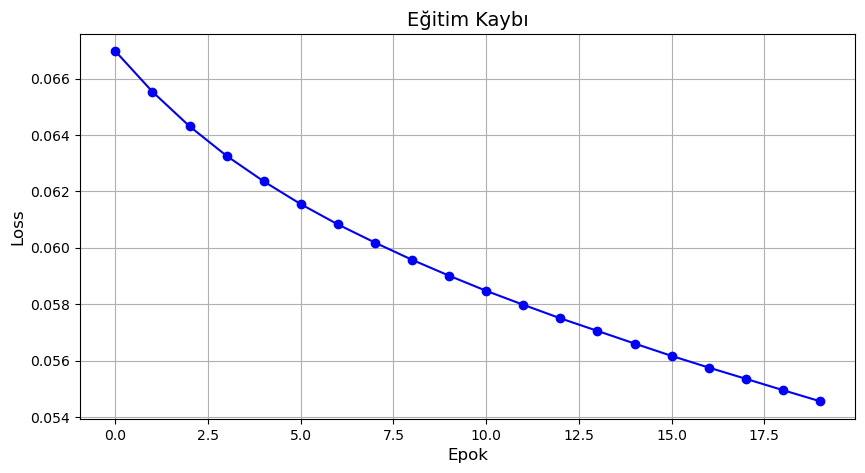

In [37]:
# Loss grafiği
plt.figure(figsize=(10,5))
plt.plot(train_losses, 'b-o')
plt.title("Eğitim Kaybı", fontsize=14)
plt.xlabel("Epok", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

_, y_pred_train = torch.max(model(data_torch).data, 1)
_, y_pred_test = torch.max(model(test_torch).data, 1)
y_pred_train = [7-int(y_pred_train[i]) for i in range(len(y_pred_train))]
y_pred_test = [7-int(y_pred_test[i]) for i in range(len(y_pred_test))]

print("Training")
print(classification_report(train_labels, y_pred_train))
print("Testing")
print(classification_report(test_labels, y_pred_test))

Training
              precision    recall  f1-score   support

           0       0.31      1.00      0.47       439
           1       0.96      0.60      0.74       349
           2       0.99      0.43      0.60       277
           3       0.96      0.10      0.19       220
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00       139
           6       0.00      0.00      0.00       110
           7       0.00      0.00      0.00        88

    accuracy                           0.44      1797
   macro avg       0.40      0.27      0.25      1797
weighted avg       0.53      0.44      0.37      1797

Testing
              precision    recall  f1-score   support

           0       0.36      1.00      0.53       221
           1       0.82      0.30      0.44       175
           2       0.04      0.07      0.05       140
           3       0.00      0.00      0.00       112
           4       0.00      0.00      0.00        88
       

C:\Users\kuantum9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kuantum9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kuantum9\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kuantum9\anaconda3\Lib

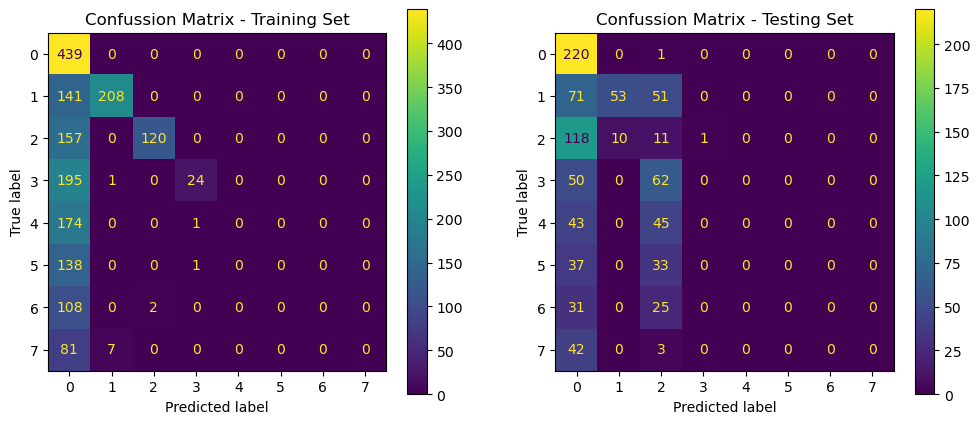

In [47]:
#Confussion Matrix
cm_tr=confusion_matrix(train_labels, y_pred_train)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
cm_ts=confusion_matrix(test_labels, y_pred_test)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
disp_tr.plot(ax=ax[0])
ax[0].set_title("Confussion Matrix - Training Set")
disp_ts.plot(ax=ax[1])
ax[1].set_title("Confussion Matrix - Testing Set")
plt.show()